## Опционально если импорты не пройдут и потом ещё нужно kernel перезагрузить

In [1]:
# ! pip install spandrel
# ! pip install -U albumentations

## Нужно импортнуть библиотеки

In [2]:
# --- Базовые и Системные ---
import os
import random
import time
import gc
import glob
import requests

# --- Обработка Данных и Математика ---
import numpy as np
import pandas as pd
from PIL import Image
import cv2

# --- PyTorch ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.amp import GradScaler, autocast
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

# --- Модели ---
import timm
import spandrel

# --- Аугментации ---
import albumentations as A
from albumentations.pytorch import ToTensorV2

# --- Метрики и Утилиты Машинного Обучения ---
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold

# --- Визуализация и Прогресс ---
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from collections import Counter
from transformers import pipeline

2025-04-30 07:14:53.051714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745997293.241572      93 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745997293.297517      93 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Пути исправить надо
* Достаточно только BASE_INPUT_PATH и OUTPUT_DIR исправить

*   `BASE_INPUT_PATH`: должен указывать на директорию, где лежит `sample_submission.csv` и подпапка `data` (в которой `train` и `test`)
*   `OUTPUT_DIR`:  должен указывать на директорию, куда скрипт имеет право записывать файлы (обработанные данные SR, модели, сабмишены, визуализации)

In [ ]:
# --- Глобальные Пути ---
BASE_INPUT_PATH = '/kaggle/input/dl-2025-competition-1/'
OUTPUT_DIR = "/kaggle/working/"

# для блока со сравнением методов апскейлинга
COMPARISON_OUTPUT_DIR = os.path.join(OUTPUT_DIR, 'sr_visualizations_comparison')
OUTPUT_DIR_VIZ_DEFAULT = os.path.join(OUTPUT_DIR, 'sr_visualizations')

# пути к данным для обучения моделей/ получения формата сабмишшена
SAMPLE_SUB_PATH = os.path.join(BASE_INPUT_PATH, 'sample_submission.csv')
DATA_ROOT = os.path.join(BASE_INPUT_PATH, 'data')
ORIGINAL_TRAIN_DATA_DIR = os.path.join(DATA_ROOT, 'train')
ORIGINAL_TEST_IMG_DIR = os.path.join(DATA_ROOT, 'test')

# пути для сохранения моделей
PROCESSED_DATA_DIR = os.path.join(OUTPUT_DIR, "data_processed_sr_128_v2") # Папка для SR данных
GAN_MODEL_DIR = os.path.join(OUTPUT_DIR, "gan_models") # Папка для моделей GAN
GENERATED_DATA_DIR = os.path.join(OUTPUT_DIR, "generated_data") # Папка для сохранения сгенеренных картинок (если нужно)
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(GAN_MODEL_DIR, exist_ok=True)
# os.makedirs(GENERATED_DATA_DIR, exist_ok=True) # Создаем, если будем сохранять картинки с гана

## Блок кода для просмотра примеров всех классов

In [ ]:
# NUM_IMAGES_PER_CLASS = 10
# FIG_COLS = 5
# NUM_ROWS = 2

# train_dataset_viz = datasets.ImageFolder(ORIGINAL_TRAIN_DATA_DIR)
# print(f"Найдено классов: {len(train_dataset_viz.classes)}")

# class_names = train_dataset_viz.classes
# class_indices = list(range(len(class_names)))

# for current_class_index in class_indices:
#     class_name = class_names[current_class_index]
#     print(f"\n--- Обработка класса: '{class_name}' (индекс: {current_class_index}) ---")

#     indices_of_target_class = [i for i, target in enumerate(train_dataset_viz.targets) if target == current_class_index]

#     num_to_select = min(NUM_IMAGES_PER_CLASS, len(indices_of_target_class))
#     random_indices = random.sample(indices_of_target_class, num_to_select)

#     plt.figure(figsize=(FIG_COLS * 2.5, NUM_ROWS * 2.5))
#     plt.suptitle(f"Класс: '{class_name}' (индекс: {current_class_index})", fontsize=14)

#     for i, idx in enumerate(random_indices):
#         image, label = train_dataset_viz[idx]

#         plt.subplot(NUM_ROWS, FIG_COLS, i + 1)
#         plt.imshow(image)
#         plt.title(f"Индекс: {idx}", fontsize=8)
#         plt.axis('off')

#     for i in range(num_to_select, NUM_ROWS * FIG_COLS):
#          plt.subplot(NUM_ROWS, FIG_COLS, i + 1)
#          plt.axis('off')

#     plt.tight_layout(rect=[0, 0, 1, 0.95])
#     plt.show()

# print("\n--- Визуализация всех классов завершена ---")

просто посмотрел какие вообще классы есть, какие есть проблемы \
классы разделены вроде корректно, но самая большая проблема это разрешение изображений

## Блок кода для просмотра примеров конкретного класса

In [ ]:
# TARGET_CLASS_NAME = '8'
# NUM_IMAGES_TO_SHOW = 100
# FIG_COLS = 5

# train_dataset_viz = datasets.ImageFolder(ORIGINAL_TRAIN_DATA_DIR)

# target_class_index = train_dataset_viz.class_to_idx[TARGET_CLASS_NAME]

# indices_of_target_class = [i for i, target in enumerate(train_dataset_viz.targets) if target == target_class_index]

# num_to_select = min(NUM_IMAGES_TO_SHOW, len(indices_of_target_class))
# random_indices = random.sample(indices_of_target_class, num_to_select)

# num_rows = (num_to_select + FIG_COLS - 1) // FIG_COLS

# fig, axes = plt.subplots(num_rows, FIG_COLS, figsize=(FIG_COLS * 2, num_rows * 2.2)) 
# axes = axes.flatten()

# for i, idx in enumerate(random_indices):
#     image, label = train_dataset_viz[idx]
#     ax = axes[i]
#     ax.imshow(image)
#     ax.set_title(f"Idx: {idx}\n{image.size[0]}x{image.size[1]}", fontsize=7)
#     ax.axis('off')

# for i in range(num_to_select, len(axes)):
#     axes[i].axis('off')

# fig.suptitle(f"Примеры изображений класса: {TARGET_CLASS_NAME}", fontsize=16, y=1.02)
# plt.tight_layout(rect=[0, 0, 1, 0.97])
# plt.show()

In [ ]:
full_train_dataset = datasets.ImageFolder(root=ORIGINAL_TRAIN_DATA_DIR)

class_names = full_train_dataset.classes

train_targets = full_train_dataset.targets
print(f"Получено {len(train_targets)} меток.")

print("\n--- Анализ Баланса Классов ---")
class_counts = Counter(train_targets)

class_counts_named = {class_names[i]: class_counts.get(i, 0) for i in range(len(class_names))}

counts_df = pd.DataFrame(list(class_counts_named.items()), columns=['Class', 'Count'])
counts_df = counts_df.sort_values(by='Count', ascending=False)

print("Распределение по классам (Топ 10 самых частых):")
print(counts_df.head(10))
print("\nРаспределение по классам (Топ 10 самых редких):")
print(counts_df.tail(10))

Получено 9510 меток.

--- Анализ Баланса Классов ---
Распределение по классам (Топ 10 самых частых):
   Class  Count
84    85    150
93    93    150
21    28    149
36    41    149
91    91    147
55    59    146
61    64    144
12     2    143
9     17    140
52    56    139

Распределение по классам (Топ 10 самых редких):
   Class  Count
45     5     45
66    69     44
75    77     44
19    26     44
97    97     40
68    70     38
57    60     37
38    43     34
90    90     34
16    23     32


Всего 9510 изображений и 100 классов \
Есть дисбаланс классов и количество изображений на класс варьируется от 150 (например, классы 85, 93) до 32 (класс 23) \
Разрешение 32x32 пикселя \
Классы: животные (наземные, водные, насекомые), объекты, структуры и природные сцены (деревья)

---
## Мысли по поводу дальнейших шагов:
1. Картинки ужасного качества, значит надо апскейлить в как можно больше раз (4 максимально обычно)
2. Дисбаланс классов весами решу
3. Буду использовать наилучшую модель для CIFAR 100 несмотря на то что он какой-то "побитый", а если конкретнее, то эту:
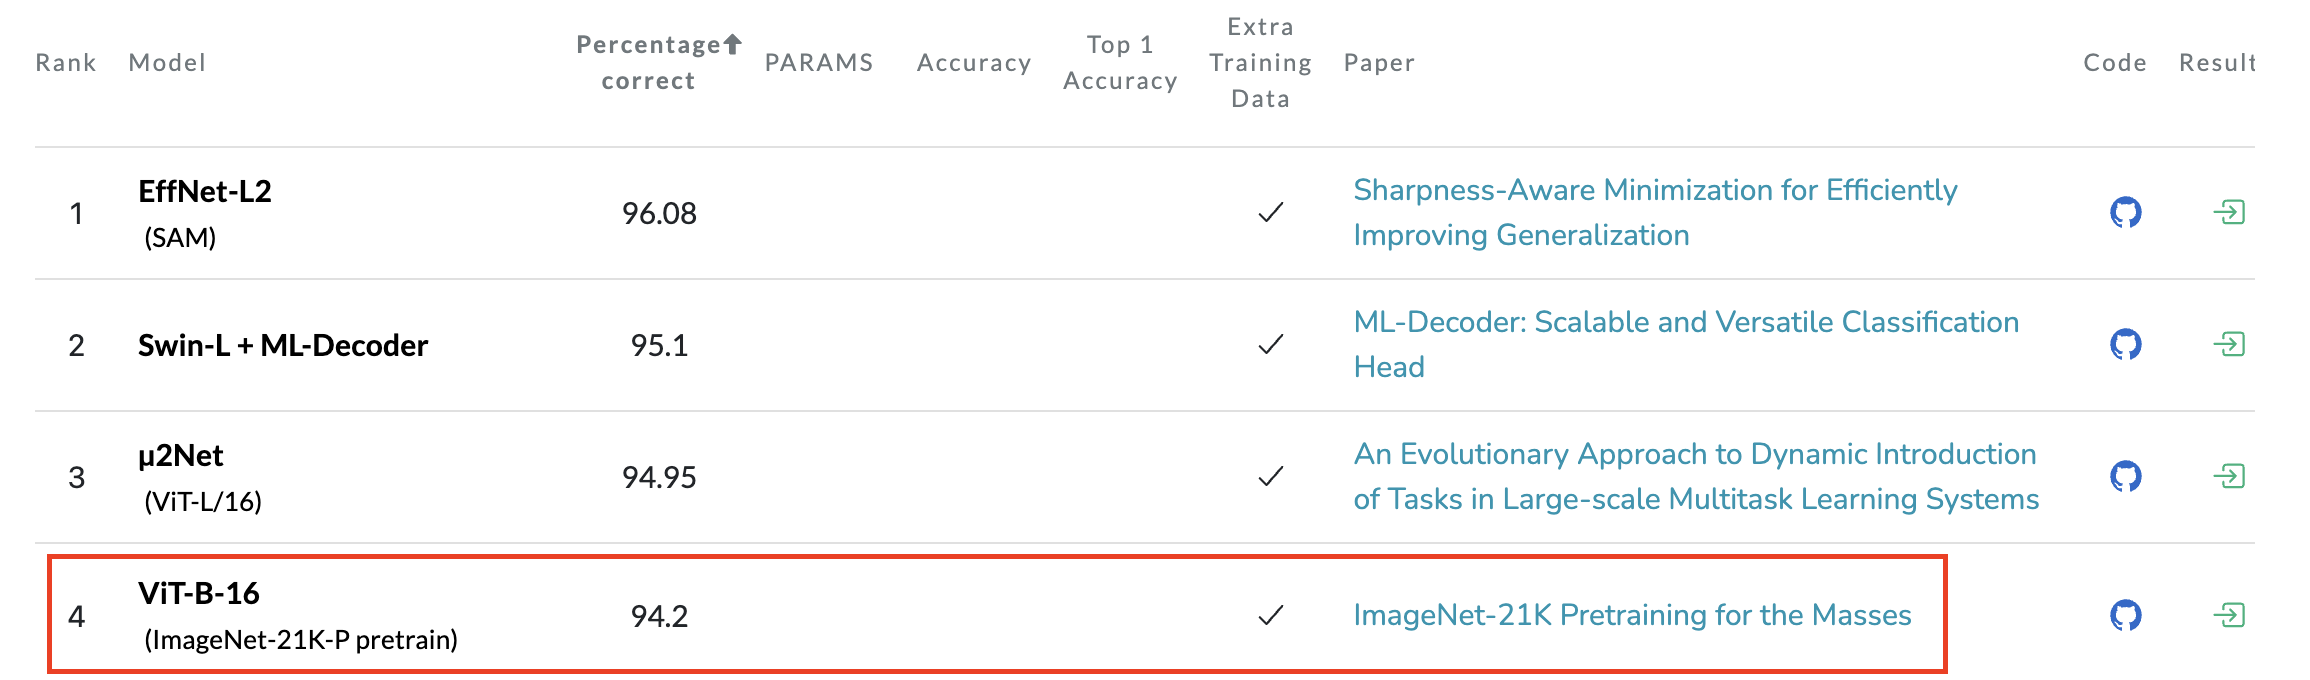
- не 1 или 2 или 3 т.к. они оч тяжёлая и в GPU кагла не помещается/реализацию нужно будет писат т.к. в timm нет их
4. "Побитость" буду решать аугментациями, а именно точки чёрные добавлять, цветовую гамму менять и тд
---

Asset 4xRealWebPhoto_v3_atd.safetensors downloaded.


/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


config.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/49.1M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/152 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


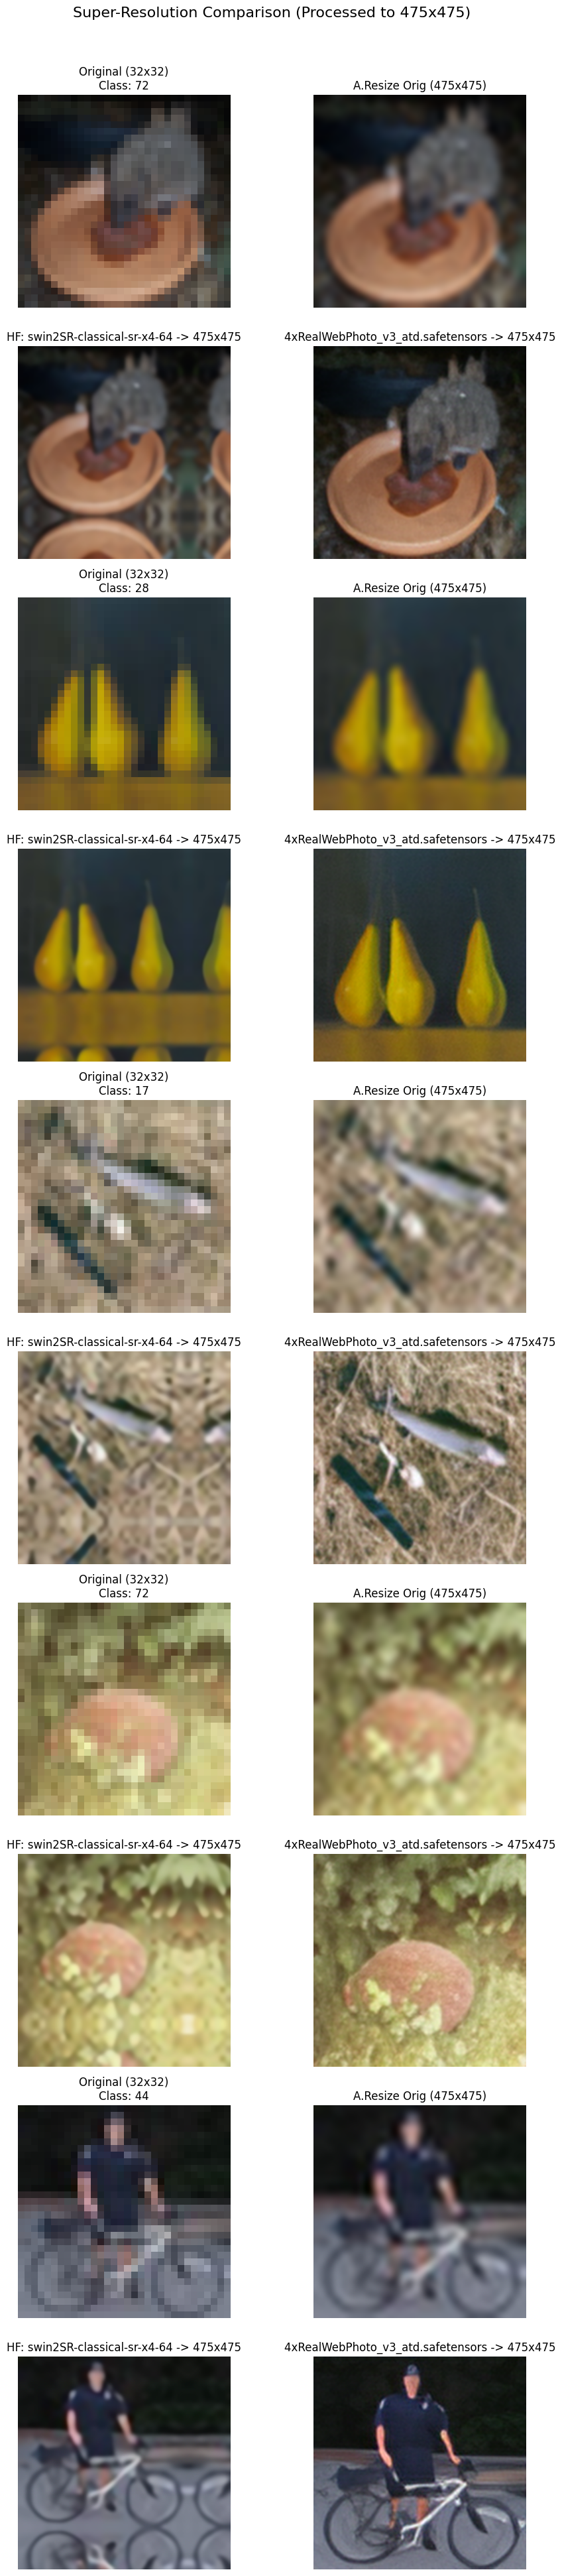

In [ ]:
# --- Вспомогательные функции ---
def seed_everything(seed):
    """Фиксирует сиды для воспроизводимости."""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

def download_github_release_asset(owner, repo, tag, asset_filename, output_dir):
    download_url = f"https://github.com/{owner}/{repo}/releases/download/{tag}/{asset_filename}"
    local_filepath = os.path.join(output_dir, asset_filename)
    os.makedirs(output_dir, exist_ok=True)
    if not os.path.exists(local_filepath):
        print(f"Downloading {asset_filename}...")
        response = requests.get(download_url, stream=True, timeout=120)
        response.raise_for_status()
        total_size_in_bytes = int(response.headers.get('content-length', 0))
        block_size = 1024 * 4
        progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True, desc=f"Downloading {asset_filename}", leave=False)
        with open(local_filepath, 'wb') as file:
            for data in response.iter_content(block_size): progress_bar.update(len(data)); file.write(data)
        progress_bar.close()
        print(f"Asset {asset_filename} downloaded.")
    return local_filepath


def select_random_images(train_data_dir, num_examples=5, seed=42):
    """Находит пути к изображениям и выбирает num_examples случайных."""
    seed_everything(seed)
    all_train_files = glob.glob(os.path.join(train_data_dir, '*/*.png'))
    actual_num_examples = min(num_examples, len(all_train_files))
    selected_paths = random.sample(all_train_files, actual_num_examples)
    selected_class_names = [os.path.basename(os.path.dirname(path)) for path in selected_paths]
    return selected_paths, selected_class_names


# --- Основная функция визуализации ---
def visualize_super_resolution(
    train_data_dir: str,
    output_dir: str = OUTPUT_DIR_VIZ_DEFAULT,
    num_examples: int = 5,
    selection_seed: int = 42,
    # --- Параметры Albumentations Resize ---
    resize_interpolation = cv2.INTER_CUBIC, # Метод интерполяции для A.Resize до 224x224
    target_size: int = 224, # Целевой размер для всех обработанных изображений
    # --- Параметры Spandrel ---
    visualize_spandrel: bool = True,
    spandrel_local_model_path: str | None = None,
    spandrel_github_owner: str | None = None,
    spandrel_github_repo: str | None = None,
    spandrel_github_tag: str | None = None,
    spandrel_asset_filename: str | None = None,
    spandrel_download_dir: str | None = None,
    # --- Параметры Hugging Face ---
    visualize_hf: bool = True,
    hf_model_name: str | None = "caidas/swin2SR-classical-sr-x4-64",
    # --- Общие параметры ---
    device: str | None = None,
    save_plots: bool = True,
    show_plots: bool = True,
    figsize_per_example: tuple[int, int] = (10, 8),
    main_title_prefix: str = "Super-Resolution Comparison",
    clear_memory: bool = True,
):
    """Выполняет и визуализирует SR, приводя все результаты к target_size. Минимальная версия."""
    seed_everything(selection_seed)
    os.makedirs(output_dir, exist_ok=True)

    # Определение устройства
    if device is None:
        runtime_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        runtime_device = torch.device(device)

    # Выбор изображений
    example_paths, example_class_names = select_random_images(
        train_data_dir=train_data_dir,
        num_examples=num_examples,
        seed=selection_seed
    )
    actual_num_examples = len(example_paths)
    if actual_num_examples == 0:
        return

    # Настройка фигуры matplotlib: 2 строки и 2 колонки НА КАЖДЫЙ пример
    fig_total_height = figsize_per_example[1] * actual_num_examples
    fig_width = figsize_per_example[0]
    fig, axes = plt.subplots(actual_num_examples * 2, 2, figsize=(fig_width, fig_total_height), squeeze=False)

    # --- Загрузка моделей ---
    sr_model_spandrel = None
    model_filename_short_spandrel = "N/A"
    if visualize_spandrel:
        model_path_spandrel = None
        if spandrel_local_model_path:
            model_path_spandrel = spandrel_local_model_path
        elif spandrel_github_owner and spandrel_github_repo and spandrel_github_tag and spandrel_asset_filename:
             download_target_dir = spandrel_download_dir or os.path.join(output_dir, "spandrel_models")
             model_path_spandrel = download_github_release_asset(
                 owner=spandrel_github_owner, repo=spandrel_github_repo, tag=spandrel_github_tag,
                 asset_filename=spandrel_asset_filename, output_dir=download_target_dir
             )
        if model_path_spandrel:
            model_filename_short_spandrel = os.path.basename(model_path_spandrel)
            sr_model_spandrel = spandrel.ModelLoader().load_from_file(model_path_spandrel).to(runtime_device)
            sr_model_spandrel.eval()

    sr_pipeline_hf = None
    hf_model_short_name = "N/A"
    if visualize_hf and hf_model_name:
        hf_model_short_name = hf_model_name.split('/')[-1]
        hf_device_id = 0 if runtime_device.type == 'cuda' else -1
        sr_pipeline_hf = pipeline("image-to-image", model=hf_model_name, device=hf_device_id)

    # Трансформация для изменения размера до target_size
    resize_to_target = A.Resize(height=target_size, width=target_size, interpolation=resize_interpolation)

    # --- Обработка и визуализация каждого примера ---
    for i, (img_path, class_name) in enumerate(zip(example_paths, example_class_names)):
        original_pil_image = Image.open(img_path).convert('RGB')
        original_np_image = np.array(original_pil_image)
        h, w, _ = original_np_image.shape

        # Индексы осей для текущего примера (2x2 сетка)
        ax_orig = axes[i * 2, 0]
        ax_resize = axes[i * 2, 1]
        ax_hf = axes[i * 2 + 1, 0]
        ax_spandrel = axes[i * 2 + 1, 1]

        # --- 1. Оригинал ---
        ax_orig.imshow(original_pil_image)
        ax_orig.set_title(f"Original ({w}x{h})\nClass: {class_name}")
        ax_orig.axis('off')

        # --- 2. Albumentations Resize оригинала до target_size ---
        resized_original_np = resize_to_target(image=original_np_image)['image']
        ax_resize.imshow(resized_original_np)
        ax_resize.set_title(f"A.Resize Orig ({target_size}x{target_size})")
        ax_resize.axis('off')

        # --- 3. Hugging Face SR -> Resize до target_size ---
        if sr_pipeline_hf:
            upscaled_pil_hf = sr_pipeline_hf(original_pil_image)
            upscaled_np_hf = np.array(upscaled_pil_hf)
            # Изменяем размер результата SR до target_size
            resized_upscaled_hf = resize_to_target(image=upscaled_np_hf)['image']
            ax_hf.imshow(resized_upscaled_hf)
            ax_hf.set_title(f"HF: {hf_model_short_name} -> {target_size}x{target_size}")
        else:
            ax_hf.text(0.5, 0.5, 'HF SR Disabled', ha='center', va='center', fontsize=9)
        ax_hf.axis('off')

        # --- 4. Spandrel SR -> Resize до target_size ---
        if sr_model_spandrel:
            img_tensor = torch.from_numpy(np.transpose(original_np_image / 255.0, (2, 0, 1))).float().unsqueeze(0).to(runtime_device)
            with torch.no_grad():
                output_tensor = sr_model_spandrel(img_tensor)
            output_image = output_tensor.data.squeeze().float().cpu().clamp_(0, 1).numpy()
            upscaled_np_spandrel = (output_image * 255.0).astype(np.uint8)
            if upscaled_np_spandrel.ndim == 3 and upscaled_np_spandrel.shape[0] == 3:
                upscaled_np_spandrel = np.transpose(upscaled_np_spandrel, (1, 2, 0))

            # Изменяем размер результата SR до target_size
            resized_upscaled_spandrel = resize_to_target(image=upscaled_np_spandrel)['image']
            ax_spandrel.imshow(resized_upscaled_spandrel)
            ax_spandrel.set_title(f"{model_filename_short_spandrel} -> {target_size}x{target_size}")
            del img_tensor, output_tensor, output_image # Очистка внутри цикла
        else:
             ax_spandrel.text(0.5, 0.5, 'Spandrel SR Disabled', ha='center', va='center', fontsize=9)
        ax_spandrel.axis('off')


    # --- Финальные настройки и отображение/сохранение ---
    fig.suptitle(f"{main_title_prefix} (Processed to {target_size}x{target_size})", fontsize=16)
    plt.tight_layout(rect=[0, 0.01, 1, 0.97]) # Отрегулирован rect для suptitle

    if save_plots:
        save_suffix = ""
        if visualize_hf and hf_model_name:
             save_suffix += f"_hf-{hf_model_short_name}"
        if visualize_spandrel and model_filename_short_spandrel != "N/A":
             save_suffix += f"_sp-{os.path.splitext(model_filename_short_spandrel)[0]}"
        if not save_suffix:
            save_suffix = "_visualization"
        save_path = os.path.join(output_dir, f"sr_comparison_2x2{save_suffix}.png")
        plt.savefig(save_path)

    if show_plots:
        plt.show()
    else:
        plt.close(fig)

    # --- Очистка памяти ---
    del sr_model_spandrel, sr_pipeline_hf
    if clear_memory:
        gc.collect()
        if torch.cuda.is_available():
             torch.cuda.empty_cache()


visualize_super_resolution(
    train_data_dir=ORIGINAL_TRAIN_DATA_DIR,
    output_dir=os.path.join(COMPARISON_OUTPUT_DIR, "run_compare_2x2"),
    num_examples=5,
    selection_seed=444,
    resize_interpolation=cv2.INTER_LANCZOS4,
    target_size=475,
    visualize_spandrel=True,
    spandrel_github_owner="Phhofm",
    spandrel_github_repo="models",
    spandrel_github_tag="4xRealWebPhoto_v3_atd",
    spandrel_asset_filename="4xRealWebPhoto_v3_atd.safetensors",
    visualize_hf=True,
    hf_model_name="caidas/swin2SR-classical-sr-x4-64",
    save_plots=False,
    show_plots=True,
    clear_memory=True
)

чтобы не было майнкрафта, мыла и трёхколёсного велосипеда - использую нормальную модель с гитхаба:\
https://github.com/Phhofm/models/releases/tag/4xRealWebPhoto_v3_atd \
У этого создателя там ещё много крутых есть+вот тут потестить можно разные модельки - https://huggingface.co/spaces/Phips/Upscaler \
да, лицо эта модель тоже плохо определила, но было бы слишком великолепно

## Основной блок обучения

In [ ]:
# --- 1. Конфигурация ---
def setup_config(**kwargs):
    config = {
        "seed": 999,
        "num_workers": 2,
        "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        "use_amp": True,
        "validation_split": 0.2,
        # --- Классификатор ---
        "img_size": 224,
        "resize_interpolation": cv2.INTER_LANCZOS4,
        "num_classes": 100,
        "model_name": "vit_base_patch16_224_in21k",
        "model_timm_name": "vit_base_patch16_224_in21k",
        "pretrained": True,
        "batch_size": 64,
        "epochs": 15,
        "lr": 3e-5,
        "weight_decay": 0.03,
        "warmup_epochs": 2,
        "scheduler": 'CosineAnnealingLR',
        "label_smoothing": 0.1,
        "early_stopping_patience": 5,
        "augmentation_level": "advanced", # 'none', 'basic', 'advanced'
        "use_class_weights": True,
        # --- Оффлайн SR ---
        "use_offline_sr": True, # Включить/выключить SR
        "sr_batch_size": 32,
        "spandrel_github_owner": "Phhofm", "spandrel_github_repo": "models",
        "spandrel_github_tag": "4xRealWebPhoto_v3_atd",
        "spandrel_asset_filename": "4xRealWebPhoto_v3_atd.safetensors",
        "spandrel_download_dir": os.path.join(OUTPUT_DIR, "spandrel_models"),
        "processed_train_dir": os.path.join(PROCESSED_DATA_DIR, "train"),
        "processed_test_dir": os.path.join(PROCESSED_DATA_DIR, "test"),
        # --- GAN Аугментация ---
        "use_generator_augmentation": False, # Включить/выключить GAN
        "generator_type": "GAN",
        "gan_latent_dim": 100,
        "gan_img_size": 32,
        "gan_epochs": 50,
        "gan_batch_size": 128,
        "gan_lr": 2e-4,
        "gan_betas": (0.5, 0.999),
        "generated_data_ratio": 0.5,
        "gan_generator_path": os.path.join(GAN_MODEL_DIR, "gan_generator.pth"),
        "gan_force_retrain": False # Переобучать ли GAN, если файл с моделбю уже есть
    }
    config["scheduler_params"] = {"CosineAnnealingLR": {"eta_min": 1e-7}}
    config.update(kwargs)
    # Имена файлов
    aug_str = f"_aug-{config['augmentation_level']}"
    sr_str = "_sr" if config["use_offline_sr"] else "_nosr"
    gen_str = "_gan" if config["use_generator_augmentation"] and not config["use_offline_sr"] else "" # GAN можно испрльзовать только без SR
    config["model_save_name"] = f"best_model_{config['model_name']}{sr_str}{gen_str}{aug_str}.pth"
    config["submission_filename"] = f"submission_{config['model_name']}{sr_str}{gen_str}{aug_str}.csv"
    return config

# --- 2. Оффлайн Предобработка SR ---
def preprocess_dataset_with_sr(config):
    # Функция остается без изменений (с проверкой на существование данных)
    if not config["use_offline_sr"]:
        return
    if os.path.exists(config["processed_train_dir"]) and os.path.exists(config["processed_test_dir"]):
         train_files_check = glob.glob(os.path.join(ORIGINAL_TRAIN_DATA_DIR, "*/*.png"))
         test_files_check = glob.glob(os.path.join(ORIGINAL_TEST_IMG_DIR, "*.png"))
         processed_train_count = len(glob.glob(os.path.join(config["processed_train_dir"], "*/*.png")))
         processed_test_count = len(glob.glob(os.path.join(config["processed_test_dir"], "*.png")))
         if processed_train_count >= len(train_files_check) and processed_test_count >= len(test_files_check):
             return

    device = config["device"]; sr_batch_size = config["sr_batch_size"]
    out_train_dir = config["processed_train_dir"]; out_test_dir = config["processed_test_dir"]
    os.makedirs(out_train_dir, exist_ok=True); os.makedirs(out_test_dir, exist_ok=True)

    model_path_spandrel = download_github_release_asset(
        owner=config["spandrel_github_owner"], repo=config["spandrel_github_repo"],
        tag=config["spandrel_github_tag"], asset_filename=config["spandrel_asset_filename"],
        output_dir=config["spandrel_download_dir"]
    )
    if not model_path_spandrel or not os.path.exists(model_path_spandrel):
         raise FileNotFoundError("SR model file not found after download attempt.")

    print("Loading SR model...")
    sr_model = spandrel.ModelLoader().load_from_file(model_path_spandrel).to(device); sr_model.eval()
    print("SR model loaded.")

    def process_batch(image_paths_batch, output_dir_batch):
        batch_images_np = []; valid_indices = []; original_paths = []
        for idx, img_path in enumerate(image_paths_batch):
             # Простая загрузка, без try-except для прототипа
             img_pil = Image.open(img_path).convert('RGB')
             img_np = np.array(img_pil)
             batch_images_np.append(img_np)
             valid_indices.append(idx)
             original_paths.append(img_path)
        if not batch_images_np: return

        batch_images_np = np.stack(batch_images_np)
        batch_tensor = torch.from_numpy(np.transpose(batch_images_np / 255.0, (0, 3, 1, 2))).float().to(device)
        with torch.no_grad():
            with autocast(device_type=device.type, dtype=torch.float16, enabled=False):
                output_batch_tensor = sr_model(batch_tensor)
            output_batch_tensor = output_batch_tensor.float()
        output_batch_np = output_batch_tensor.data.cpu().numpy()
        output_batch_np = np.nan_to_num(output_batch_np, nan=0.0, posinf=1.0, neginf=0.0) # Оставляем на всякий случай
        output_batch_np = np.clip(output_batch_np, 0.0, 1.0) # Оставляем клиппинг
        upscaled_batch_np = (output_batch_np * 255.0).astype(np.uint8)
        if upscaled_batch_np.ndim == 4 and upscaled_batch_np.shape[1] == 3:
             upscaled_batch_np = np.transpose(upscaled_batch_np, (0, 2, 3, 1))
        else: return # Пропускаем если формат не тот

        for i, original_idx in enumerate(valid_indices):
            img_to_save_np = upscaled_batch_np[i]; original_path = original_paths[i]; img_basename = os.path.basename(original_path)
            if output_dir_batch == out_test_dir:
                output_path = os.path.join(output_dir_batch, img_basename)
            else:
                class_name = os.path.basename(os.path.dirname(original_path))
                output_class_dir = os.path.join(output_dir_batch, class_name)
                os.makedirs(output_class_dir, exist_ok=True)
                output_path = os.path.join(output_class_dir, img_basename)
            Image.fromarray(img_to_save_np).save(output_path) # Без try-except
        del batch_tensor, output_batch_tensor, output_batch_np, upscaled_batch_np

    train_class_folders = sorted(os.listdir(ORIGINAL_TRAIN_DATA_DIR))
    print(f"Starting SR preprocessing for {len(train_class_folders)} train classes...")
    for class_name in tqdm(train_class_folders, desc="Preprocessing Train (SR)", leave=False):
        # ... (внутренняя логика без изменений, кроме удаления проверок) ...
        in_class_dir = os.path.join(ORIGINAL_TRAIN_DATA_DIR, class_name); out_class_dir = os.path.join(out_train_dir, class_name); os.makedirs(out_class_dir, exist_ok=True); image_files_to_process = []
        all_files_in_class = glob.glob(os.path.join(in_class_dir, "*.png"))
        for img_path in all_files_in_class:
             output_path = os.path.join(out_class_dir, os.path.basename(img_path));
             if not os.path.exists(output_path): image_files_to_process.append(img_path)
        if not image_files_to_process: continue
        for i in range(0, len(image_files_to_process), sr_batch_size):
            process_batch(image_files_to_process[i:i + sr_batch_size], out_train_dir);
        if device.type == 'cuda': torch.cuda.empty_cache()

    print("Starting SR preprocessing for test images...")
    all_test_files = glob.glob(os.path.join(ORIGINAL_TEST_IMG_DIR, "*.png")); test_files_to_process = []
    for img_path in all_test_files:
         output_path = os.path.join(out_test_dir, os.path.basename(img_path));
         if not os.path.exists(output_path): test_files_to_process.append(img_path)
    if test_files_to_process:
        for i in tqdm(range(0, len(test_files_to_process), sr_batch_size), desc="Preprocessing Test (SR)", leave=False):
            process_batch(test_files_to_process[i:i + sr_batch_size], out_test_dir);
    # else: print("All test images seem preprocessed.") # Убрано
    if device.type == 'cuda': torch.cuda.empty_cache()

    print("SR preprocessing finished.")
    del sr_model; gc.collect();
    if device.type == 'cuda': torch.cuda.empty_cache()

# --- 3. Аугментации (basic, advanced) ---
def get_augmentations(config):
    img_size = config["img_size"]; interpolation = config["resize_interpolation"]
    mean = [0.485, 0.456, 0.406]; std = [0.229, 0.224, 0.225]
    level = config.get("augmentation_level", "basic") # По умолчанию basic

    # Трансформации для валидации и теста
    val_test_transforms = A.Compose([
        A.Resize(height=img_size, width=img_size, interpolation=interpolation),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ])

    if level == 'basic':
        train_transforms = A.Compose([
            A.HorizontalFlip(p=0.5),
            # Простой ресайз до нужного размера и нормализация
            A.Resize(height=img_size, width=img_size, interpolation=interpolation),
            A.Normalize(mean=mean, std=std),
            ToTensorV2(),
        ])
    elif level == 'advanced':
        train_transforms = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.Affine(scale=(0.9, 1.1), translate_percent=(0.05, 0.08), rotate=(-10, 10),
                     p=0.5, border_mode=cv2.BORDER_REFLECT),
            A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.5),
            A.CoarseDropout(
                num_holes_range=(1, 8),
                hole_height_range=(int(img_size*0.05), int(img_size*0.1)),
                hole_width_range=(int(img_size*0.05), int(img_size*0.1)),
                fill=0, p=0.4
            ),
            A.Resize(height=img_size, width=img_size, interpolation=interpolation),
            A.Normalize(mean=mean, std=std),
            ToTensorV2(),
        ])
    else: # 'none' или что то другое
        train_transforms = val_test_transforms

    return train_transforms, val_test_transforms, None

# --- 4. Датасет ---
class ImageDataset(Dataset):
    def __init__(self, file_paths, targets=None, transforms=None, is_test=False, config=None):
        self.file_paths = file_paths; self.targets = targets; self.transforms = transforms; self.is_test = is_test
        self.config = config

        # Проверка на случай, если config не передан, но нужен в else
        if self.transforms is None and self.config is None:
             print("Warning: ImageDataset created without transforms and config. Fallback resize/normalize might fail.")

    def __len__(self): return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            image_np = np.array(image)
            if self.transforms:
                image_tensor = self.transforms(image=image_np)['image']
            else:
                if self.config:
                    img_size = self.config.get("img_size", 224)
                    interpolation = self.config.get("resize_interpolation", cv2.INTER_LANCZOS4)
                    image_resized = cv2.resize(image_np, (img_size, img_size), interpolation=interpolation)
                    image_tensor = torch.from_numpy(np.transpose(image_resized, (2, 0, 1))).float() / 255.0
                else:
                    # Если нет ни transforms, ни config - возвращаем ошибку и пустой тензор
                    print(f"Error: No transforms or config provided for ImageDataset. Cannot process {img_path}")
                    img_size = 224 # Дефолтный размер для пустого тензора
                    if self.is_test: return torch.zeros((3, img_size, img_size)), 0
                    else: return torch.zeros((3, img_size, img_size)), torch.tensor(0, dtype=torch.long)

            if self.is_test:
                img_id = int(os.path.basename(img_path).split('.')[0])
                return image_tensor, img_id
            else:
                return image_tensor, torch.tensor(self.targets[idx], dtype=torch.long)
        except Exception as e:
            print(f"Error loading or processing image {img_path}: {e}. Returning zeros.")
            img_size = self.config.get("img_size", 224) if self.config else 224
            if self.is_test: return torch.zeros((3, img_size, img_size)), 0
            else: return torch.zeros((3, img_size, img_size)), torch.tensor(0, dtype=torch.long)

# --- GAN Компоненты ---
# Простой генератор DCGAN (вход: латентный вектор, выход: 3x32x32)
class Generator(nn.Module):
    def __init__(self, latent_dim=100, channels=3):
        super().__init__()
        self.init_size = 4 # Начальный размер карты признаков
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2), # 4x4 -> 8x8
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2), # 8x8 -> 16x16
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2), # 16x16 -> 32x32
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh() # Выход в диапазоне [-1, 1]
        )
    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

# Простой дискриминатор DCGAN (вход: 3x32x32, выход: 1)
class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super().__init__()
        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn: block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block
        self.model = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )
        ds_size = 32 // 2 ** 4 # Размер карты после 4 сверток stride=2
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())
    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        return validity

# --- Обучение GAN ---
def train_gan(config, gan_train_loader):
    device = config['device']
    latent_dim = config['gan_latent_dim']
    lr = config['gan_lr']
    betas = config['gan_betas']
    epochs = config['gan_epochs']
    generator_path = config['gan_generator_path']

    # Проверка, нужно ли обучать
    if not config['gan_force_retrain'] and os.path.exists(generator_path):
        print(f"GAN generator already exists at {generator_path}. Skipping training.")
        return

    print(f"Starting GAN training for {epochs} epochs...")
    generator = Generator(latent_dim).to(device)
    discriminator = Discriminator().to(device)
    adversarial_loss = nn.BCELoss().to(device)
    optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=betas)
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=betas)

    for epoch in range(epochs):
        d_loss_epoch = 0.0
        g_loss_epoch = 0.0
        num_batches = 0
        loop = tqdm(gan_train_loader, desc=f"GAN Epoch {epoch+1}/{epochs}", leave=False)
        for i, (imgs, _) in enumerate(loop):
            num_batches += 1
            # Данные для GAN должны быть -1..1
            real_imgs = imgs.to(device) * 2 - 1 # Трансформация 0..1 -> -1..1

            # Метки для BCELoss
            valid = torch.full((real_imgs.size(0), 1), 0.9, device=device, dtype=torch.float) # Сглаживание для реальных (0.9 вместо 1)
            fake = torch.zeros((real_imgs.size(0), 1), device=device, dtype=torch.float) # Метки для фейков

            # -----------------
            #  Тренировка Дискриминатора
            # -----------------
            optimizer_D.zero_grad()
            # Шум для генератора
            z = torch.randn(real_imgs.size(0), latent_dim, device=device)
            gen_imgs = generator(z).detach()

            # Ошибка на реальных и фейковых
            real_loss = adversarial_loss(discriminator(real_imgs), valid)
            fake_loss = adversarial_loss(discriminator(gen_imgs), fake)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

            # -----------------
            #  Тренировка Генератора
            # -----------------
            optimizer_G.zero_grad()
            # Новые сгенерированные изображения (не detach)
            gen_imgs_for_g = generator(z)
            # Ошибка генератора - насколько хорошо он обманул дискриминатор
            g_loss = adversarial_loss(discriminator(gen_imgs_for_g), valid) # G хочет, чтобы D думал, что они реальные

            g_loss.backward()
            optimizer_G.step()

            d_loss_epoch += d_loss.item()
            g_loss_epoch += g_loss.item()
            loop.set_postfix(d_loss=d_loss.item(), g_loss=g_loss.item())

        avg_d_loss = d_loss_epoch / num_batches if num_batches > 0 else 0
        avg_g_loss = g_loss_epoch / num_batches if num_batches > 0 else 0
        print(f"GAN Epoch {epoch+1}/{epochs} | D Loss: {avg_d_loss:.4f} | G Loss: {avg_g_loss:.4f}")

    # Сохраняем генератор
    torch.save(generator.state_dict(), generator_path)
    print(f"GAN generator saved to {generator_path}")
    del generator, discriminator, optimizer_G, optimizer_D, adversarial_loss
    gc.collect()
    if device.type == 'cuda': torch.cuda.empty_cache()

# --- Генерация данных GAN ---
def generate_gan_data(config, num_images):
    device = config['device']
    latent_dim = config['gan_latent_dim']
    generator_path = config['gan_generator_path']
    batch_size = config['gan_batch_size'] # Можно использовать батч для генерации

    if not os.path.exists(generator_path):
        print(f"Error: Trained GAN generator not found at {generator_path}")
        return None # Возвращаем None, если генератор не найден

    print(f"Loading trained GAN generator from {generator_path}")
    generator = Generator(latent_dim).to(device)
    generator.load_state_dict(torch.load(generator_path, map_location=device))
    generator.eval()

    generated_images = []
    print(f"Generating {num_images} synthetic images...")
    with torch.no_grad():
        for _ in tqdm(range(0, num_images, batch_size), desc="Generating GAN data"):
            current_batch_size = min(batch_size, num_images - len(generated_images))
            if current_batch_size <= 0: break
            z = torch.randn(current_batch_size, latent_dim, device=device)
            gen_imgs_batch = generator(z)
            # Переводим обратно в диапазон 0..1 и на CPU
            gen_imgs_batch_cpu = (gen_imgs_batch * 0.5 + 0.5).cpu()
            generated_images.append(gen_imgs_batch_cpu)

    del generator
    gc.collect(); torch.cuda.empty_cache()

    if not generated_images:
        return None

    # Объединяем батчи в один тензор
    all_generated_images = torch.cat(generated_images, dim=0)
    print(f"Generated {all_generated_images.shape[0]} images of shape {all_generated_images.shape[1:]}")
    return all_generated_images

# --- Объединенный Датасет (Оригинальный + GAN) ---
class CombinedDataset(Dataset):
    def __init__(self, original_dataset, generated_images_tensor, generated_targets, transforms=None):
        self.original_dataset = original_dataset
        self.generated_images = generated_images_tensor
        self.generated_targets = generated_targets
        self.transforms = transforms # Применяем те же трансформации к сгенерированным

        self.original_len = len(original_dataset)
        self.generated_len = len(generated_images_tensor)

    def __len__(self):
        return self.original_len + self.generated_len

    def __getitem__(self, idx):
        if idx < self.original_len:
            # Получаем из оригинального датасета
            return self.original_dataset[idx]
        else:
            # Получаем из сгенерированных данных
            gen_idx = idx - self.original_len
            image_tensor = self.generated_images[gen_idx] # Уже тензор 0..1
            target = self.generated_targets[gen_idx]

            # Применяем трансформации, если они есть
            # Трансформации ожидают numpy array uint8
            # Поэтому конвертируем тензор обратно
            image_np = (image_tensor.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
            if self.transforms:
                 image_tensor = self.transforms(image=image_np)['image']
            # Если трансформаций нет, оставляем как тензор 0..1 (не должно случиться, т.к. берем train_transforms)

            return image_tensor, torch.tensor(target, dtype=torch.long)


# --- 5-7: get_classifier_model, get_criterion, get_optimizer, get_scheduler, train_one_epoch, validate_one_epoch, predict_final ---
def get_classifier_model(config):
    model = timm.create_model(
        config["model_timm_name"],
        pretrained=config["pretrained"],
        num_classes=config["num_classes"]
    )
    print(f"Loaded model {config['model_timm_name']} with {sum(p.numel() for p in model.parameters())/1e6:.2f}M parameters.")
    return model.to(config["device"])

def get_criterion(config, class_weights):
    weights = class_weights.to(config["device"]) if config.get("use_class_weights", False) and class_weights is not None else None
    ls = config.get("label_smoothing", 0.0)
    return nn.CrossEntropyLoss(weight=weights, label_smoothing=ls)

def get_optimizer(model, config):
    lr = config.get('lr', 1e-3)
    wd = config.get('weight_decay', 1e-6)
    return optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

def get_scheduler(optimizer, config, train_loader_len):
    base_lr = config.get('lr', 1e-3)
    warmup_epochs = config.get("warmup_epochs", 0)
    total_epochs = config.get("epochs", 10)
    scheduler_name = config.get("scheduler", 'CosineAnnealingLR')
    scheduler_params = config.get("scheduler_params", {}).get(scheduler_name, {})
    scheduler_after_warmup = None
    warmup_iters = 0
    if train_loader_len > 0: warmup_iters = train_loader_len * warmup_epochs
    if scheduler_name == 'CosineAnnealingLR' and total_epochs > warmup_epochs:
        t_max_epochs = total_epochs - warmup_epochs
        t_max_val = max(1, train_loader_len * t_max_epochs if train_loader_len > 0 else 1)
        eta_min = scheduler_params.get('eta_min', 1e-7)
        T_max_final = scheduler_params.get('T_max', t_max_val)
        scheduler_after_warmup = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max_final, eta_min=eta_min)
    return scheduler_after_warmup, warmup_iters, base_lr

def train_one_epoch(model, loader, criterion, optimizer, device, scaler, use_amp, current_iter, warmup_iters, base_lr, scheduler_after_warmup):
    model.train(); running_loss = 0.0; total_samples = 0
    loop = tqdm(loader, desc=" Train Batch", leave=False)
    for images, labels in loop:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        if images.nelement() == 0: continue # Пропускаем пустой батч
        current_lr = base_lr
        if warmup_iters > 0 and current_iter < warmup_iters:
            lr_scale = (current_iter + 1) / warmup_iters; current_lr = base_lr * lr_scale
            for pg in optimizer.param_groups: pg['lr'] = current_lr
        elif warmup_iters > 0 and current_iter == warmup_iters:
             for pg in optimizer.param_groups: pg['lr'] = base_lr; current_lr = base_lr
        optimizer.zero_grad(set_to_none=True)
        with autocast(device_type=device.type, dtype=torch.float16, enabled=use_amp):
            outputs = model(images); loss = criterion(outputs, labels)
        if use_amp: scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        else: loss.backward(); optimizer.step()
        if scheduler_after_warmup and (warmup_iters == 0 or current_iter >= warmup_iters):
             scheduler_after_warmup.step()
        if optimizer.param_groups: current_lr = optimizer.param_groups[0]['lr']
        running_loss += loss.item() * images.size(0); total_samples += images.size(0); current_iter += 1
        loop.set_postfix(loss=loss.item(), lr=f"{current_lr:.2e}")
    epoch_loss = running_loss / total_samples if total_samples > 0 else 0.0
    return epoch_loss, current_iter

def validate_one_epoch(model, loader, criterion, device, use_amp):
    # Упрощенная версия
    model.eval(); running_loss = 0.0; all_preds = []; all_labels = []; total_samples = 0
    loop = tqdm(loader, desc=" Val Batch  ", leave=False)
    with torch.no_grad():
        for images, labels in loop:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            if images.nelement() == 0: continue
            with autocast(device_type=device.type, dtype=torch.float16, enabled=use_amp):
                outputs = model(images); loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
            total_samples += images.size(0)
            loop.set_postfix(loss=loss.item())
    if not all_labels: return 0.0, 0.0, 0.0
    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    epoch_loss = running_loss / total_samples if total_samples > 0 else 0.0
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc, epoch_f1

def predict_final(model, config, test_image_paths, transforms_val_test):
    # Упрощенная версия TTA
    device = config["device"]; use_amp = config["use_amp"]
    test_dataset_orig = ImageDataset(test_image_paths, targets=None, transforms=transforms_val_test, is_test=True, config=config)
    test_batch_size = max(16, config.get("batch_size", 64))
    test_loader_orig = DataLoader(test_dataset_orig, batch_size=test_batch_size * 2, shuffle=False, num_workers=config.get("num_workers", 2), pin_memory=True)
    img_size = config.get("img_size", 224); interpolation = config.get("resize_interpolation", cv2.INTER_LANCZOS4)
    mean = [0.485, 0.456, 0.406]; std = [0.229, 0.224, 0.225]
    transforms_tta_flip = A.Compose([
        A.HorizontalFlip(p=1.0), A.Resize(height=img_size, width=img_size, interpolation=interpolation),
        A.Normalize(mean=mean, std=std), ToTensorV2(),
    ])
    test_dataset_flip = ImageDataset(test_image_paths, targets=None, transforms=transforms_tta_flip, is_test=True, config=config)
    test_loader_flip = DataLoader(test_dataset_flip, batch_size=test_batch_size * 2, shuffle=False, num_workers=config.get("num_workers", 2), pin_memory=True)

    model.eval(); all_preds_probs_orig = []; all_preds_probs_flip = []; collected_ids = []
    print("TTA: Predicting on original images...")
    with torch.no_grad():
        for images_batch, img_ids_batch in tqdm(test_loader_orig, desc="Predicting Orig", leave=False):
            if images_batch.nelement() == 0: continue
            images_batch = images_batch.to(device, non_blocking=True)
            with autocast(device_type=device.type, dtype=torch.float16, enabled=use_amp):
                outputs = model(images_batch); probs = torch.softmax(outputs, dim=1)
            all_preds_probs_orig.append(probs.cpu()); collected_ids.append(img_ids_batch.cpu())
    print("TTA: Predicting on horizontally flipped images...")
    with torch.no_grad():
        for images_batch, _ in tqdm(test_loader_flip, desc="Predicting Flip", leave=False):
            if images_batch.nelement() == 0: continue
            images_batch = images_batch.to(device, non_blocking=True)
            with autocast(device_type=device.type, dtype=torch.float16, enabled=use_amp):
                outputs = model(images_batch); probs = torch.softmax(outputs, dim=1)
            all_preds_probs_flip.append(probs.cpu())

    if not collected_ids: return np.array([]), np.array([])
    collected_ids = torch.cat(collected_ids).numpy(); all_preds_probs_orig = torch.cat(all_preds_probs_orig, dim=0)
    if not all_preds_probs_flip: # Если флип не удался
        final_preds = torch.argmax(all_preds_probs_orig, dim=1).numpy()
    else:
        all_preds_probs_flip = torch.cat(all_preds_probs_flip, dim=0)
        if all_preds_probs_orig.shape[0] == all_preds_probs_flip.shape[0]:
             avg_probs = (all_preds_probs_orig + all_preds_probs_flip) / 2.0
             final_preds = torch.argmax(avg_probs, dim=1).numpy()
        else:
             final_preds = torch.argmax(all_preds_probs_orig, dim=1).numpy()
    return np.array(collected_ids), np.array(final_preds)

# --- 8. Основная функция запуска ---
def run_experiment(config):
    seed_everything(config["seed"])
    start_run_time = time.time()

    # --- Определение путей к данным ---
    if config.get("use_offline_sr", False):
        print(f"Using SR data. Checking/running preprocessing...")
        preprocess_dataset_with_sr(config)
        CURRENT_TRAIN_DATA_DIR = config["processed_train_dir"]; CURRENT_TEST_IMG_DIR = config["processed_test_dir"]
    else:
        print("Using original data directories (SR is disabled).")
        CURRENT_TRAIN_DATA_DIR = ORIGINAL_TRAIN_DATA_DIR
        CURRENT_TEST_IMG_DIR = ORIGINAL_TEST_IMG_DIR

    # --- Загрузка путей и создание правильных меток ---
    print("Collecting file paths and creating labels...")
    all_train_paths_list = []; all_train_targets_list = []
    expected_num_classes = 100
    numeric_folder_names = [fn for fn in os.listdir(ORIGINAL_TRAIN_DATA_DIR) if fn.isdigit()]
    for folder_name in tqdm(numeric_folder_names, desc="Processing class folders"):
        class_index = int(folder_name)
        class_path = os.path.join(CURRENT_TRAIN_DATA_DIR, folder_name)
        if not os.path.isdir(class_path): continue
        files_in_class = glob.glob(os.path.join(class_path, '*.png'))
        for file_path in files_in_class:
            all_train_paths_list.append(file_path)
            all_train_targets_list.append(class_index)
    config["num_classes"] = expected_num_classes
    all_train_paths = np.array(all_train_paths_list); all_train_targets = np.array(all_train_targets_list)
    print(f"Collected {len(all_train_paths)} training files.")

    # --- Генерация GAN данных (если включено и SR отключен) ---
    generated_images_tensor = None
    generated_targets = None
    if config.get("use_generator_augmentation", False):
        if config.get("use_offline_sr", False):
            print("Warning: GAN augmentation is enabled but SR is also enabled. GAN augmentation will be SKIPPED because mixing resolutions is not supported in this simple setup.")
        else:
            print("GAN augmentation enabled. Training/Loading GAN generator...")
            # Создаем загрузчик для ОРИГИНАЛЬНЫХ данных 32x32 для обучения GAN
            gan_transform = transforms.Compose([
                transforms.Resize(config['gan_img_size']),
                transforms.ToTensor(),
            ])
            gan_train_dataset = torchvision.datasets.ImageFolder(ORIGINAL_TRAIN_DATA_DIR, transform=gan_transform)
            gan_train_loader = DataLoader(gan_train_dataset, batch_size=config['gan_batch_size'], shuffle=True, num_workers=config['num_workers'])
            # Обучаем GAN
            train_gan(config, gan_train_loader)
            # Генерируем данные
            num_original_train = len(all_train_paths)
            num_to_generate = int(num_original_train * config.get("generated_data_ratio", 0.5))
            generated_images_tensor = generate_gan_data(config, num_to_generate)
            if generated_images_tensor is not None:
                # Генерируем случайные метки для сгенерированных изображений (безусловный GAN)
                generated_targets = np.random.randint(0, config['num_classes'], size=len(generated_images_tensor))
                print(f"Generated {len(generated_images_tensor)} images with random labels.")
            del gan_train_dataset, gan_train_loader # Освобождаем память

    # --- Расчет весов классов ---
    class_weights = None
    if config.get("use_class_weights", False):
        print("Calculating class weights...")
        unique_classes_found, counts = np.unique(all_train_targets, return_counts=True)
        # Добавляем сгенерированные таргеты, если они есть
        combined_targets = np.concatenate((all_train_targets, generated_targets)) if generated_targets is not None else all_train_targets
        weights = compute_class_weight('balanced', classes=np.unique(combined_targets), y=combined_targets)
        final_weights = torch.ones(config["num_classes"], dtype=torch.float)
        present_classes = sorted(list(np.unique(combined_targets)))
        if len(weights) == len(present_classes):
            weight_map = {cls_idx: weight for cls_idx, weight in zip(present_classes, weights)}
            for i in range(config["num_classes"]): final_weights[i] = weight_map.get(i, 1.0)
            class_weights = final_weights
            print("Class weights calculated and will be used.")

    # --- Разделение на трейн/валидацию ---
    # Валидация ВСЕГДА на оригинальных данных
    train_paths, val_paths, train_targets_orig, val_targets = train_test_split(
         all_train_paths, all_train_targets,
         test_size=config.get("validation_split", 0.2),
         random_state=config.get("seed", 999),
         stratify=all_train_targets
    )
    print(f"Original train samples: {len(train_paths)}, Validation samples: {len(val_paths)}")

    # --- Получение аугментаций ---
    train_transforms, val_transforms, _ = get_augmentations(config)

    # --- Создание датасетов ---
    # Передаем config в конструктор
    train_dataset_orig_part = ImageDataset(train_paths, train_targets_orig, transforms=None, config=config) # Для CombinedDataset
    val_dataset = ImageDataset(val_paths, val_targets, transforms=val_transforms, config=config) # Для валидации

    # Тренировочный датасет: либо оригинальный, либо комбинированный
    if generated_images_tensor is not None and generated_targets is not None:
         train_dataset = CombinedDataset(train_dataset_orig_part, generated_images_tensor, generated_targets, transforms=train_transforms)
         print(f"Using CombinedDataset with {len(train_dataset_orig_part)} original and {len(generated_images_tensor)} generated samples.")
    else:
         # Если GAN не используется, создаем обычный трейн датасет
         train_dataset = ImageDataset(train_paths, train_targets_orig, transforms=train_transforms, config=config)
         print("Using original training data only.")


    # --- Создание загрузчиков ---
    num_workers = config.get("num_workers", 2); batch_size = config.get("batch_size", 64)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size * 2, shuffle=False, num_workers=num_workers, pin_memory=True)

    # --- Инициализация модели и компонентов обучения ---
    device = config.get("device"); print(f"Using device: {device}")
    classifier_model = get_classifier_model(config);
    criterion = get_criterion(config, class_weights);
    optimizer = get_optimizer(classifier_model, config)
    train_loader_len = len(train_loader); scheduler, warmup_iters, base_lr = get_scheduler(optimizer, config, train_loader_len);
    use_amp = config.get("use_amp", False); scaler = GradScaler(device=device, enabled=use_amp)

    # --- Основной цикл обучения ---
    history = {'train_loss': [], 'val_loss': [], 'val_f1': [], 'val_acc': []}; best_metric_val = -np.inf; epochs_no_improve = 0; current_train_iter = 0
    model_save_path = os.path.join(OUTPUT_DIR, config.get("model_save_name", "best_model.pth"))
    metric_to_monitor = 'val_acc'; patience = config.get("early_stopping_patience", 5)

    print(f"Starting classifier training for {config['epochs']} epochs...")
    for epoch in range(config['epochs']):
        epoch_start_time = time.time()
        train_loss, current_train_iter = train_one_epoch(classifier_model, train_loader, criterion, optimizer, device, scaler, use_amp, current_train_iter, warmup_iters, base_lr, scheduler)
        val_loss, val_acc, val_f1 = validate_one_epoch(classifier_model, val_loader, criterion, device, use_amp)
        epoch_duration = time.time() - epoch_start_time
        history['train_loss'].append(train_loss); history['val_loss'].append(val_loss); history['val_f1'].append(val_f1); history['val_acc'].append(val_acc)
        print(f"Epoch {epoch+1}/{config['epochs']} | Time: {epoch_duration:.2f}s | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}", end="")
        current_metric = history[metric_to_monitor][-1]
        if current_metric > best_metric_val:
            best_metric_val = current_metric
            torch.save(classifier_model.state_dict(), model_save_path)
            epochs_no_improve = 0; print(" *Best model saved*")
        else:
            epochs_no_improve += 1; print(f" (Patience {epochs_no_improve}/{patience})")
        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered after epoch {epoch+1}.")
            break

    # --- Завершение обучения и вывод результатов ---
    print(f"\nClassifier training finished. Best validation accuracy: {best_metric_val:.4f}")
    run_duration = time.time() - start_run_time
    print(f"Total run time: {run_duration/60:.2f} minutes")

    # --- Отрисовка графиков ---
    if history['val_acc']:
        print("Plotting metrics...")
        plt.figure(figsize=(12, 5));
        plt.subplot(1, 2, 1); plt.plot(history['train_loss'], label='Train Loss'); plt.plot(history['val_loss'], label='Val Loss'); plt.title('Loss'); plt.xlabel('Epoch'); plt.legend(); plt.grid(True)
        plt.subplot(1, 2, 2); plt.plot(history['val_acc'], label=f'Val Accuracy (Best: {best_metric_val:.4f})'); plt.plot(history['val_f1'], label='Val F1 Score', linestyle='--'); plt.title(f'Validation Metrics (Stopped after {len(history["val_acc"])} epochs)'); plt.xlabel('Epoch'); plt.legend(); plt.grid(True);
        plt.tight_layout(); plt.show()

    # --- Предсказание на тесте ---
    print("Starting prediction on test set...")
    if os.path.exists(model_save_path):
        best_classifier_model = get_classifier_model(config)
        print(f"Loading best model weights from: {model_save_path}")
        state_dict = torch.load(model_save_path, map_location=device, weights_only=True)
        best_classifier_model.load_state_dict(state_dict); best_classifier_model.eval()
        test_image_paths_unsorted = glob.glob(os.path.join(CURRENT_TEST_IMG_DIR, "*.png"))
        if test_image_paths_unsorted:
             test_image_paths = sorted(test_image_paths_unsorted, key=lambda x: int(os.path.basename(x).split('.')[0]))
             print(f"Found {len(test_image_paths)} test images, sorted by ID.")
             _, val_transforms_pred, _ = get_augmentations(config)
             test_ids, test_preds = predict_final(best_classifier_model, config, test_image_paths, val_transforms_pred)
             if len(test_ids) > 0 and len(test_ids) == len(test_preds):
                submission_df = pd.DataFrame({'id': test_ids, 'target': test_preds})
                submission_df['id'] = submission_df['id'].astype(int); submission_df = submission_df.sort_values(by='id')
                submission_filename = os.path.join(OUTPUT_DIR, config.get("submission_filename", "submission.csv"))
                submission_df.to_csv(submission_filename, index=False)
                print(f"Submission file saved to: {submission_filename}")
        del best_classifier_model, state_dict

    # --- Очистка памяти ---
    print("Cleaning up resources...")
    vars_to_delete = ['classifier_model', 'train_loader', 'val_loader', 'train_dataset', 'val_dataset',
                      'optimizer', 'scheduler', 'scaler', 'class_weights', 'best_classifier_model', 'state_dict',
                      'all_train_paths', 'all_train_targets', 'train_paths', 'val_paths', 'train_targets_orig', 'val_targets',
                      'generated_images_tensor', 'generated_targets', 'original_train_part_dataset']
    for var_name in vars_to_delete:
        if var_name in locals(): del locals()[var_name]
        if var_name in globals(): del globals()[var_name]
    gc.collect()
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    print("Cleanup complete.")

    return best_metric_val

## Обычная модель с простыми (basic) аугментациями, без апскейлинга и использования GAN

Using original data directories (SR is disabled).


Processing class folders:   0%|          | 0/100 [00:00<?, ?it/s]

Collected 9510 training files.
Calculating class weights...
Class weights calculated and will be used.
Original train samples: 7608, Validation samples: 1902
Using original training data only.
Using device: cuda


model.safetensors:   0%|          | 0.00/410M [00:00<?, ?B/s]

Loaded model vit_base_patch16_224.augreg_in21k with 85.88M parameters.
Starting classifier training for 15 epochs...


 Train Batch:   0%|          | 0/118 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15 | Time: 138.10s | Train Loss: 3.7191 | Val Loss: 1.0047 | Val Acc: 0.7492 | Val F1: 0.7458 *Best model saved*


 Train Batch:   0%|          | 0/118 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 2/15 | Time: 136.86s | Train Loss: 0.5919 | Val Loss: 0.5945 | Val Acc: 0.8433 | Val F1: 0.8441 *Best model saved*


 Train Batch:   0%|          | 0/118 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 3/15 | Time: 136.80s | Train Loss: 0.1720 | Val Loss: 0.6133 | Val Acc: 0.8607 | Val F1: 0.8587 *Best model saved*


 Train Batch:   0%|          | 0/118 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 4/15 | Time: 136.81s | Train Loss: 0.0497 | Val Loss: 0.5193 | Val Acc: 0.8733 | Val F1: 0.8726 *Best model saved*


 Train Batch:   0%|          | 0/118 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 5/15 | Time: 136.74s | Train Loss: 0.0169 | Val Loss: 0.5590 | Val Acc: 0.8864 | Val F1: 0.8840 *Best model saved*


 Train Batch:   0%|          | 0/118 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 6/15 | Time: 136.81s | Train Loss: 0.0049 | Val Loss: 0.5155 | Val Acc: 0.8948 | Val F1: 0.8936 *Best model saved*


 Train Batch:   0%|          | 0/118 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 7/15 | Time: 136.83s | Train Loss: 0.0041 | Val Loss: 0.5186 | Val Acc: 0.8901 | Val F1: 0.8892 (Patience 1/5)


 Train Batch:   0%|          | 0/118 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 8/15 | Time: 136.80s | Train Loss: 0.0019 | Val Loss: 0.5162 | Val Acc: 0.8912 | Val F1: 0.8893 (Patience 2/5)


 Train Batch:   0%|          | 0/118 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 9/15 | Time: 136.81s | Train Loss: 0.0009 | Val Loss: 0.5160 | Val Acc: 0.8922 | Val F1: 0.8905 (Patience 3/5)


 Train Batch:   0%|          | 0/118 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 10/15 | Time: 136.81s | Train Loss: 0.0008 | Val Loss: 0.5167 | Val Acc: 0.8922 | Val F1: 0.8905 (Patience 4/5)


 Train Batch:   0%|          | 0/118 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 11/15 | Time: 136.85s | Train Loss: 0.0007 | Val Loss: 0.5175 | Val Acc: 0.8927 | Val F1: 0.8911 (Patience 5/5)

Early stopping triggered after epoch 11.

Classifier training finished. Best validation accuracy: 0.8948
Total run time: 25.23 minutes
Plotting metrics...


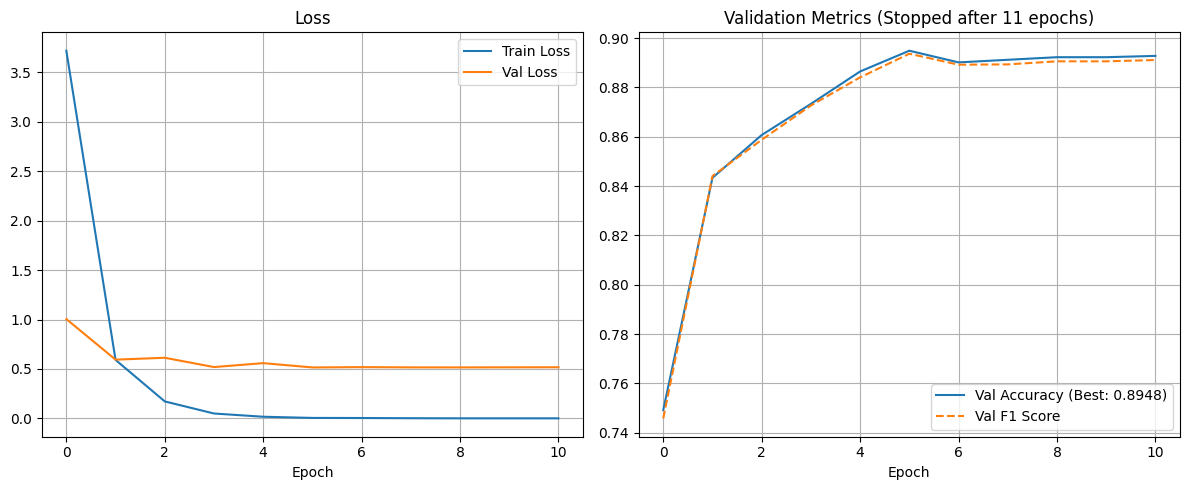

Starting prediction on test set...
Loaded model vit_base_patch16_224.augreg_in21k with 85.88M parameters.
Loading best model weights from: /kaggle/working/best_model_vit_base_patch16_224_in21k_nosr_aug-basic.pth
Found 3878 test images, sorted by ID.
TTA: Predicting on original images...


Predicting Orig:   0%|          | 0/31 [00:00<?, ?it/s]

TTA: Predicting on horizontally flipped images...


Predicting Flip:   0%|          | 0/31 [00:00<?, ?it/s]

Submission file saved to: /kaggle/working/submission_vit_base_patch16_224_in21k_nosr_aug-basic.csv
Cleaning up resources...
Cleanup complete.


In [8]:
current_config = setup_config(
        use_offline_sr=False,
        augmentation_level='basic',
        model_name="vit_base_patch16_224_in21k",
        model_timm_name="vit_base_patch16_224.augreg_in21k",
        batch_size=64,
        lr=5e-5,
        weight_decay=0.01,
        epochs=15,
        early_stopping_patience=5,
        warmup_epochs=1,
        use_class_weights=True,
        label_smoothing=0.0,
        # --- GAN Параметры ---
        use_generator_augmentation=False,
        gan_epochs=50,
        generated_data_ratio=0.2,
        gan_force_retrain=False
    )

best_val_accuracy = run_experiment(current_config)

## Модель с GAN и advanced аугментациями, но без апскейлинга

Using original data directories (SR is disabled).


Processing class folders:   0%|          | 0/100 [00:00<?, ?it/s]

Collected 9510 training files.
GAN augmentation enabled. Training/Loading GAN generator...
Starting GAN training for 50 epochs...


GAN Epoch 1/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 1/50 | D Loss: 0.6891 | G Loss: 0.7252


GAN Epoch 2/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 2/50 | D Loss: 0.6883 | G Loss: 0.7685


GAN Epoch 3/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 3/50 | D Loss: 0.6889 | G Loss: 0.7789


GAN Epoch 4/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 4/50 | D Loss: 0.6877 | G Loss: 0.7850


GAN Epoch 5/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 5/50 | D Loss: 0.6881 | G Loss: 0.7810


GAN Epoch 6/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 6/50 | D Loss: 0.6884 | G Loss: 0.7815


GAN Epoch 7/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 7/50 | D Loss: 0.6864 | G Loss: 0.7863


GAN Epoch 8/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 8/50 | D Loss: 0.6882 | G Loss: 0.7821


GAN Epoch 9/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 9/50 | D Loss: 0.6878 | G Loss: 0.7833


GAN Epoch 10/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 10/50 | D Loss: 0.6882 | G Loss: 0.7808


GAN Epoch 11/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 11/50 | D Loss: 0.6881 | G Loss: 0.7812


GAN Epoch 12/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 12/50 | D Loss: 0.6876 | G Loss: 0.7833


GAN Epoch 13/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 13/50 | D Loss: 0.6889 | G Loss: 0.7797


GAN Epoch 14/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 14/50 | D Loss: 0.6877 | G Loss: 0.7800


GAN Epoch 15/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 15/50 | D Loss: 0.6881 | G Loss: 0.7805


GAN Epoch 16/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 16/50 | D Loss: 0.6881 | G Loss: 0.7799


GAN Epoch 17/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 17/50 | D Loss: 0.6882 | G Loss: 0.7796


GAN Epoch 18/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 18/50 | D Loss: 0.6879 | G Loss: 0.7799


GAN Epoch 19/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 19/50 | D Loss: 0.6881 | G Loss: 0.7790


GAN Epoch 20/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 20/50 | D Loss: 0.6880 | G Loss: 0.7799


GAN Epoch 21/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 21/50 | D Loss: 0.6881 | G Loss: 0.7794


GAN Epoch 22/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 22/50 | D Loss: 0.6873 | G Loss: 0.7821


GAN Epoch 23/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 23/50 | D Loss: 0.6887 | G Loss: 0.7785


GAN Epoch 24/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 24/50 | D Loss: 0.6872 | G Loss: 0.7832


GAN Epoch 25/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 25/50 | D Loss: 0.6886 | G Loss: 0.7778


GAN Epoch 26/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 26/50 | D Loss: 0.6882 | G Loss: 0.7803


GAN Epoch 27/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 27/50 | D Loss: 0.6875 | G Loss: 0.7796


GAN Epoch 28/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 28/50 | D Loss: 0.6879 | G Loss: 0.7837


GAN Epoch 29/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 29/50 | D Loss: 0.6876 | G Loss: 0.7833


GAN Epoch 30/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 30/50 | D Loss: 0.6883 | G Loss: 0.7815


GAN Epoch 31/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 31/50 | D Loss: 0.6882 | G Loss: 0.7792


GAN Epoch 32/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 32/50 | D Loss: 0.6877 | G Loss: 0.7799


GAN Epoch 33/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 33/50 | D Loss: 0.6880 | G Loss: 0.7804


GAN Epoch 34/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 34/50 | D Loss: 0.6880 | G Loss: 0.7802


GAN Epoch 35/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 35/50 | D Loss: 0.6876 | G Loss: 0.7796


GAN Epoch 36/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 36/50 | D Loss: 0.6878 | G Loss: 0.7810


GAN Epoch 37/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 37/50 | D Loss: 0.6878 | G Loss: 0.7801


GAN Epoch 38/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 38/50 | D Loss: 0.6883 | G Loss: 0.7812


GAN Epoch 39/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 39/50 | D Loss: 0.6874 | G Loss: 0.7805


GAN Epoch 40/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 40/50 | D Loss: 0.6873 | G Loss: 0.7806


GAN Epoch 41/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 41/50 | D Loss: 0.6891 | G Loss: 0.7822


GAN Epoch 42/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 42/50 | D Loss: 0.6872 | G Loss: 0.7841


GAN Epoch 43/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 43/50 | D Loss: 0.6878 | G Loss: 0.7796


GAN Epoch 44/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 44/50 | D Loss: 0.6877 | G Loss: 0.7807


GAN Epoch 45/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 45/50 | D Loss: 0.6878 | G Loss: 0.7812


GAN Epoch 46/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 46/50 | D Loss: 0.6879 | G Loss: 0.7840


GAN Epoch 47/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 47/50 | D Loss: 0.6878 | G Loss: 0.7819


GAN Epoch 48/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 48/50 | D Loss: 0.6878 | G Loss: 0.7802


GAN Epoch 49/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 49/50 | D Loss: 0.6870 | G Loss: 0.7857


GAN Epoch 50/50:   0%|          | 0/75 [00:00<?, ?it/s]

GAN Epoch 50/50 | D Loss: 0.6879 | G Loss: 0.7822
GAN generator saved to /kaggle/working/gan_models/gan_generator.pth
Loading trained GAN generator from /kaggle/working/gan_models/gan_generator.pth
Generating 1902 synthetic images...


/tmp/ipykernel_93/3655642013.py:393: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(generator_path, map_location=device))


Generating GAN data:   0%|          | 0/15 [00:00<?, ?it/s]

Generated 1920 images of shape torch.Size([3, 32, 32])
Generated 1920 images with random labels.
Calculating class weights...
Class weights calculated and will be used.
Original train samples: 7608, Validation samples: 1902
Using CombinedDataset with 7608 original and 1920 generated samples.
Using device: cuda
Loaded model vit_base_patch16_224.augreg_in21k with 85.88M parameters.
Starting classifier training for 15 epochs...


 Train Batch:   0%|          | 0/148 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15 | Time: 169.53s | Train Loss: 4.4353 | Val Loss: 3.8966 | Val Acc: 0.2292 | Val F1: 0.2482 *Best model saved*


 Train Batch:   0%|          | 0/148 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 2/15 | Time: 169.55s | Train Loss: 2.2031 | Val Loss: 3.2134 | Val Acc: 0.4132 | Val F1: 0.4864 *Best model saved*


 Train Batch:   0%|          | 0/148 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 3/15 | Time: 169.55s | Train Loss: 1.8858 | Val Loss: 3.5618 | Val Acc: 0.3365 | Val F1: 0.4168 (Patience 1/5)


 Train Batch:   0%|          | 0/148 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 4/15 | Time: 169.51s | Train Loss: 1.7731 | Val Loss: 3.2269 | Val Acc: 0.4106 | Val F1: 0.4890 (Patience 2/5)


 Train Batch:   0%|          | 0/148 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 5/15 | Time: 169.57s | Train Loss: 1.7362 | Val Loss: 3.7961 | Val Acc: 0.2892 | Val F1: 0.3742 (Patience 3/5)


 Train Batch:   0%|          | 0/148 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 6/15 | Time: 169.48s | Train Loss: 1.7209 | Val Loss: 3.4034 | Val Acc: 0.4154 | Val F1: 0.4874 *Best model saved*


 Train Batch:   0%|          | 0/148 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 7/15 | Time: 169.61s | Train Loss: 1.7108 | Val Loss: 3.5634 | Val Acc: 0.3696 | Val F1: 0.4562 (Patience 1/5)


 Train Batch:   0%|          | 0/148 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 8/15 | Time: 169.82s | Train Loss: 1.6991 | Val Loss: 3.4179 | Val Acc: 0.3964 | Val F1: 0.4720 (Patience 2/5)


 Train Batch:   0%|          | 0/148 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 9/15 | Time: 169.58s | Train Loss: 1.6962 | Val Loss: 3.6113 | Val Acc: 0.3465 | Val F1: 0.4247 (Patience 3/5)


 Train Batch:   0%|          | 0/148 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 10/15 | Time: 169.61s | Train Loss: 1.6876 | Val Loss: 3.4670 | Val Acc: 0.3833 | Val F1: 0.4528 (Patience 4/5)


 Train Batch:   0%|          | 0/148 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 11/15 | Time: 169.66s | Train Loss: 1.6785 | Val Loss: 3.0111 | Val Acc: 0.5074 | Val F1: 0.5644 *Best model saved*


 Train Batch:   0%|          | 0/148 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 12/15 | Time: 169.66s | Train Loss: 1.6734 | Val Loss: 3.1873 | Val Acc: 0.4543 | Val F1: 0.5125 (Patience 1/5)


 Train Batch:   0%|          | 0/148 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 13/15 | Time: 169.56s | Train Loss: 1.6665 | Val Loss: 3.0419 | Val Acc: 0.4900 | Val F1: 0.5397 (Patience 2/5)


 Train Batch:   0%|          | 0/148 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 14/15 | Time: 169.64s | Train Loss: 1.6542 | Val Loss: 3.0603 | Val Acc: 0.4858 | Val F1: 0.5338 (Patience 3/5)


 Train Batch:   0%|          | 0/148 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 15/15 | Time: 169.62s | Train Loss: 1.6445 | Val Loss: 3.0665 | Val Acc: 0.4848 | Val F1: 0.5333 (Patience 4/5)

Classifier training finished. Best validation accuracy: 0.5074
Total run time: 46.69 minutes
Plotting metrics...


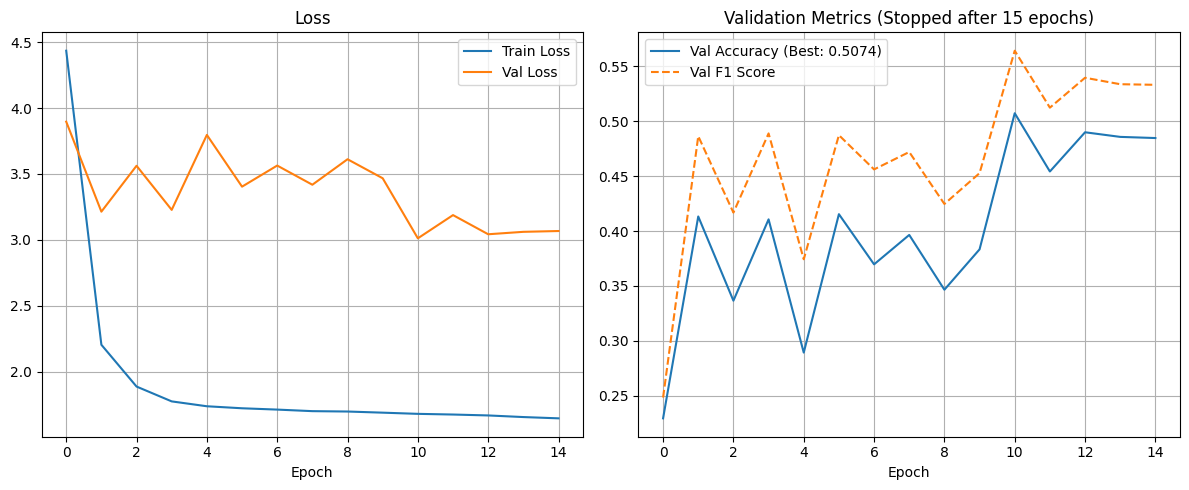

Starting prediction on test set...
Loaded model vit_base_patch16_224.augreg_in21k with 85.88M parameters.
Loading best model weights from: /kaggle/working/best_model_vit_base_patch16_224_in21k_nosr_gan_aug-advanced.pth
Found 3878 test images, sorted by ID.
TTA: Predicting on original images...


Predicting Orig:   0%|          | 0/31 [00:00<?, ?it/s]

TTA: Predicting on horizontally flipped images...


Predicting Flip:   0%|          | 0/31 [00:00<?, ?it/s]

Submission file saved to: /kaggle/working/submission_vit_base_patch16_224_in21k_nosr_gan_aug-advanced.csv
Cleaning up resources...
Cleanup complete.


In [9]:
current_config = setup_config(
    use_offline_sr=False, # нельзя ставить True в текущей реализации совместно с использованием use_generator_augmentation=True, т.к. GAN картинки 32x32 генерит
    augmentation_level='advanced',
    model_name="vit_base_patch16_224_in21k",
    model_timm_name="vit_base_patch16_224.augreg_in21k",
    batch_size=64,
    lr=3e-5,
    weight_decay=0.03,
    epochs=15,
    early_stopping_patience=5,
    warmup_epochs=2,
    use_class_weights=True,
    label_smoothing=0.1,
    # --- GAN Параметры ---
    use_generator_augmentation=True,
    gan_epochs=50,
    generated_data_ratio=0.2,
    gan_force_retrain=True
)

best_val_accuracy = run_experiment(current_config)

---
### Финальное Решение для Kaggle

В ячейке ниже расположен код и конфигурация, которые использовались для получения лучшего результата на лидерборде
- Модель: ViT-Base/16 (предобученная на ImageNet-21k)
- Входные данные: С апскейлингом (SR) до 128x128 -> Ресайз до 224x224
- Аугментации: Уровень 'advanced'
- Использовались веса классов и Label Smoothing
- GAN-аугментация отключена
- Использовалось TTA (Horizontal Flip) при предсказании
---

Using SR data. Checking/running preprocessing...


Asset 4xRealWebPhoto_v3_atd.safetensors downloaded.
Loading SR model...
SR model loaded.
Starting SR preprocessing for 100 train classes...


Preprocessing Train (SR):   0%|          | 0/100 [00:00<?, ?it/s]

Starting SR preprocessing for test images...


Preprocessing Test (SR):   0%|          | 0/122 [00:00<?, ?it/s]

SR preprocessing finished.


Processing class folders:   0%|          | 0/100 [00:00<?, ?it/s]

Collected 9510 training files.
Calculating class weights...
Class weights calculated and will be used.
Original train samples: 7608, Validation samples: 1902
Using original training data only.
Using device: cuda
Loaded model vit_base_patch16_224.augreg_in21k with 85.88M parameters.
Starting classifier training for 15 epochs...


 Train Batch:   0%|          | 0/118 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15 | Time: 138.25s | Train Loss: 5.0471 | Val Loss: 3.7359 | Val Acc: 0.2324 | Val F1: 0.2210 *Best model saved*


 Train Batch:   0%|          | 0/118 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 2/15 | Time: 138.26s | Train Loss: 2.1495 | Val Loss: 1.4577 | Val Acc: 0.8644 | Val F1: 0.8621 *Best model saved*


 Train Batch:   0%|          | 0/118 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 3/15 | Time: 138.38s | Train Loss: 1.2686 | Val Loss: 1.3195 | Val Acc: 0.8922 | Val F1: 0.8929 *Best model saved*


 Train Batch:   0%|          | 0/118 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 4/15 | Time: 138.25s | Train Loss: 1.0786 | Val Loss: 1.2685 | Val Acc: 0.9080 | Val F1: 0.9080 *Best model saved*


 Train Batch:   0%|          | 0/118 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 5/15 | Time: 138.60s | Train Loss: 1.0101 | Val Loss: 1.2437 | Val Acc: 0.9154 | Val F1: 0.9162 *Best model saved*


 Train Batch:   0%|          | 0/118 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 6/15 | Time: 138.18s | Train Loss: 0.9816 | Val Loss: 1.2314 | Val Acc: 0.9243 | Val F1: 0.9238 *Best model saved*


 Train Batch:   0%|          | 0/118 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 7/15 | Time: 138.20s | Train Loss: 0.9605 | Val Loss: 1.2176 | Val Acc: 0.9196 | Val F1: 0.9190 (Patience 1/5)


 Train Batch:   0%|          | 0/118 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 8/15 | Time: 138.25s | Train Loss: 0.9514 | Val Loss: 1.2204 | Val Acc: 0.9227 | Val F1: 0.9224 (Patience 2/5)


 Train Batch:   0%|          | 0/118 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 9/15 | Time: 138.12s | Train Loss: 0.9437 | Val Loss: 1.2215 | Val Acc: 0.9196 | Val F1: 0.9195 (Patience 3/5)


 Train Batch:   0%|          | 0/118 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 10/15 | Time: 138.24s | Train Loss: 0.9367 | Val Loss: 1.2092 | Val Acc: 0.9248 | Val F1: 0.9240 *Best model saved*


 Train Batch:   0%|          | 0/118 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 11/15 | Time: 138.21s | Train Loss: 0.9323 | Val Loss: 1.2034 | Val Acc: 0.9248 | Val F1: 0.9245 (Patience 1/5)


 Train Batch:   0%|          | 0/118 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 12/15 | Time: 138.13s | Train Loss: 0.9282 | Val Loss: 1.2046 | Val Acc: 0.9248 | Val F1: 0.9244 (Patience 2/5)


 Train Batch:   0%|          | 0/118 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 13/15 | Time: 138.26s | Train Loss: 0.9265 | Val Loss: 1.2059 | Val Acc: 0.9259 | Val F1: 0.9257 *Best model saved*


 Train Batch:   0%|          | 0/118 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 14/15 | Time: 138.25s | Train Loss: 0.9263 | Val Loss: 1.2044 | Val Acc: 0.9269 | Val F1: 0.9269 *Best model saved*


 Train Batch:   0%|          | 0/118 [00:00<?, ?it/s]

 Val Batch  :   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 15/15 | Time: 138.24s | Train Loss: 0.9247 | Val Loss: 1.2045 | Val Acc: 0.9274 | Val F1: 0.9273 *Best model saved*

Classifier training finished. Best validation accuracy: 0.9274
Total run time: 43.17 minutes
Plotting metrics...


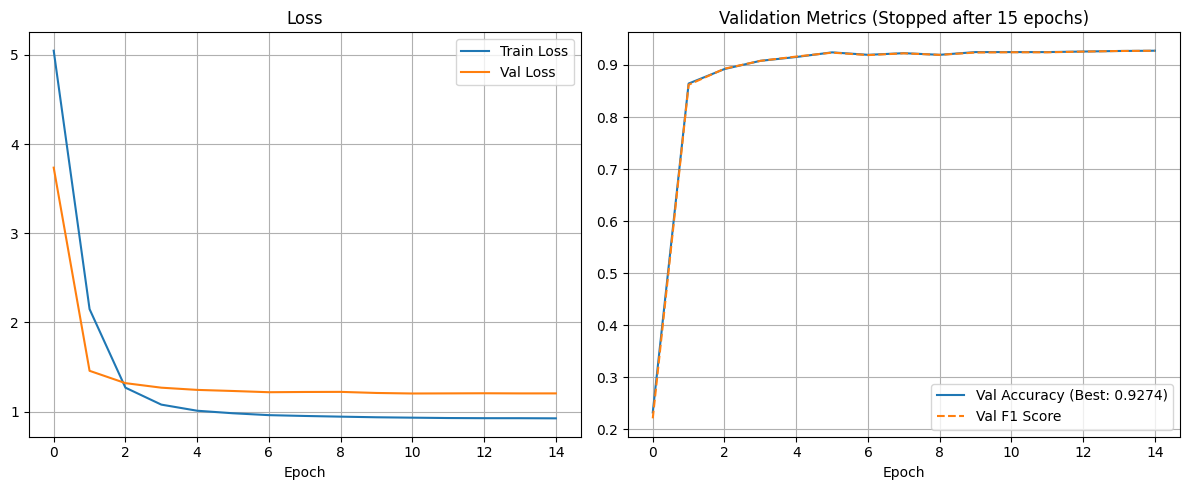

Starting prediction on test set...
Loaded model vit_base_patch16_224.augreg_in21k with 85.88M parameters.
Loading best model weights from: /kaggle/working/best_model_vit_base_patch16_224_in21k_sr_aug-advanced.pth
Found 3878 test images, sorted by ID.
TTA: Predicting on original images...


Predicting Orig:   0%|          | 0/31 [00:00<?, ?it/s]

TTA: Predicting on horizontally flipped images...


Predicting Flip:   0%|          | 0/31 [00:00<?, ?it/s]

Submission file saved to: /kaggle/working/submission_vit_base_patch16_224_in21k_sr_aug-advanced.csv
Cleaning up resources...
Cleanup complete.


In [10]:
current_config = setup_config(
    use_offline_sr=True,
    augmentation_level='advanced',
    model_name="vit_base_patch16_224_in21k",
    model_timm_name="vit_base_patch16_224.augreg_in21k",
    batch_size=64,
    lr=3e-5,
    weight_decay=0.03,
    epochs=15,
    early_stopping_patience=5,
    warmup_epochs=2,
    use_class_weights=True,
    label_smoothing=0.1,
    use_generator_augmentation=False 
)
best_val_accuracy = run_experiment(current_config)

## Что можно было попробовать ещё чтобы ещё сильнее увеличить скор?
* https://paperswithcode.com/method/autoaugment - это библиотека с автоматическими аугментациями всякими разными - https://pytorch.org/vision/main/generated/torchvision.transforms.AutoAugment.html
* kfold можно было на финальной модели затестить, но я на более слабой пробовал и особо результат лучше не стал
* возможно, стоило найти модели которые апскейлят x8, но в репозитории, который я раньше указал, таких моделей не нашёл
* Conditional GAN использовать, а не обычный
* параметры получше подобрать
* TTA улучшить добавив не только горизонтальный флип, но и повороты на несколько градусов 